# Opening multifile datasets

In many cases large datasets are spead over multiple files, so no individual file becomes too large, and operating on a subset of the data is easier without having to read the whole dataset

xarray can open multiple files as a single xarray `Dataset` with the `open_mfdataset` command. Pass it either a list of files to open, or a wildcard string that matches the desired files. 

This is useful as it can skip wasteful steps of creating intermediate datasets which are aggregations of existing data. Just load it all up and select out what is required.

Start with the required imports

In [1]:
import xarray

In [2]:
%matplotlib inline

Wildcards only work when accessing files on a local filesystem, for opendap it is necessary to  pass a list of urls. Below a list of urls are created from the individual filenames which are joined to a prefix.

In [3]:
files = ['tas_day_ACCESS1-3_historical_r1i1p1_18500101-18741231.nc', 
        'tas_day_ACCESS1-3_historical_r1i1p1_18750101-18991231.nc',
        'tas_day_ACCESS1-3_historical_r1i1p1_19000101-19241231.nc']
prefix = 'http://dapds00.nci.org.au/thredds/dodsC/rr3/CMIP5/output1/CSIRO-BOM/ACCESS1-3/historical/day/atmos/day/r1i1p1/latest/tas/'
urls = [prefix+file for file in files]
urls

['http://dapds00.nci.org.au/thredds/dodsC/rr3/CMIP5/output1/CSIRO-BOM/ACCESS1-3/historical/day/atmos/day/r1i1p1/latest/tas/tas_day_ACCESS1-3_historical_r1i1p1_18500101-18741231.nc',
 'http://dapds00.nci.org.au/thredds/dodsC/rr3/CMIP5/output1/CSIRO-BOM/ACCESS1-3/historical/day/atmos/day/r1i1p1/latest/tas/tas_day_ACCESS1-3_historical_r1i1p1_18750101-18991231.nc',
 'http://dapds00.nci.org.au/thredds/dodsC/rr3/CMIP5/output1/CSIRO-BOM/ACCESS1-3/historical/day/atmos/day/r1i1p1/latest/tas/tas_day_ACCESS1-3_historical_r1i1p1_19000101-19241231.nc']

This list is then passed to `open_mfdataset`

In [4]:
ds = xarray.open_mfdataset(urls)

The resulting dataset is pretty big, the `nbytes` attribute gives the size of the dataset in bytes. In this case it is over 3GB. The `tas` variable has 27393 daily time steps. It doesn't take a long time to load the dataset, as it is only metadata, but loading the underlying data could be time consuming depending on how much needs to be read.

In [5]:
ds.nbytes/1000**3

3.198847672

In [6]:
ds

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 145, lon: 192, time: 27393)
Coordinates:
  * lat        (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
  * lon        (lon) float64 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
    height     float64 1.5
  * time       (time) datetime64[ns] 1850-01-01T12:00:00 ... 1924-12-31T12:00:00
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] dask.array<shape=(27393, 2), chunksize=(9131, 2)>
    lat_bnds   (time, lat, bnds) float64 dask.array<shape=(27393, 145, 2), chunksize=(9131, 145, 2)>
    lon_bnds   (time, lon, bnds) float64 dask.array<shape=(27393, 192, 2), chunksize=(9131, 192, 2)>
    tas        (time, lat, lon) float32 dask.array<shape=(27393, 145, 192), chunksize=(9131, 145, 192)>
Attributes:
    institution:                     CSIRO (Commonwealth Scientific and Indus...
    institute_id:                    CSIRO-BOM
    experiment_id:                   historical
    s

Note also that extra information in the data variables section

`dask.array<shape=(27393, 145, 192), chunksize=(9131, 145, 192)>`

Dask is beyond the scope of this introduction, but xarray has assigned a dask chunking to the data variables as they are split across files. In particular the `time` dimension is split into three with 9131 values per file.

Regardless of chunking, this data set can be used as if it were a single file for the purposes of manipulations and calculations.

Now it is possible to specify a spatial subset containing Australia, using `sel`

In [7]:
tas_aus = ds.tas.sel(lat=slice(-50,-5), lon=slice(110,160))
tas_aus

<xarray.DataArray 'tas' (time: 27393, lat: 37, lon: 27)>
dask.array<shape=(27393, 37, 27), dtype=float32, chunksize=(9131, 37, 27)>
Coordinates:
  * lat      (lat) float64 -50.0 -48.75 -47.5 -46.25 ... -8.75 -7.5 -6.25 -5.0
  * lon      (lon) float64 110.6 112.5 114.4 116.2 ... 153.8 155.6 157.5 159.4
    height   float64 1.5
  * time     (time) datetime64[ns] 1850-01-01T12:00:00 ... 1924-12-31T12:00:00
Attributes:
    standard_name:     air_temperature
    long_name:         Near-Surface Air Temperature
    units:             K
    cell_methods:      time: mean
    cell_measures:     area: areacella
    associated_files:  baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLocation...

Confirm it is correct by plotting the first time point

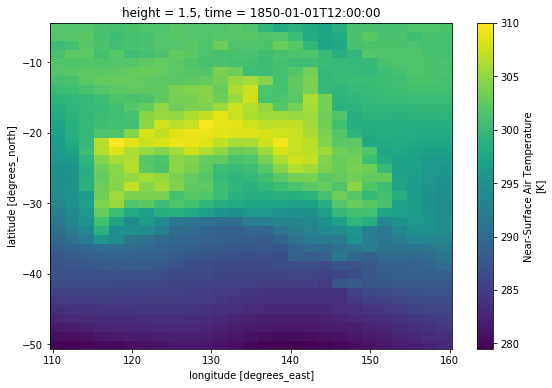

In [8]:
tas_aus.isel(time=0).plot(size=6)

So `tas_aus` is a 75 year daily temperature dataset of Australia. Any calculation can now be performed, e.g. analysing variability in space, time, season ... there are many possibilities